In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import psycopg2 as pg
import sqlalchemy as sq
import seaborn as sns
import pickle

In [4]:
def open_connection():
    conn = pg.connect(dbname='postgres', user = 'postgres', password = 123, host = 'localhost')
    return conn
def get_connection():
    '''
    FUNCTION TO CONNECT TO THE POSTGRESQL DATABASE AND RETURN THE SQLACHEMY ENGINE OBJECT
    -----------
    output: object
        SQLACHEMY ENGINE OBJECT - POSTGRESQL DATABASE CONNECTION
    '''
    user = 'postgres'
    password = 123
    host = 'localhost'
    port = 5432
    database = 'postgres'
    return sq.create_engine(url="postgresql://{0}:{1}@{2}:{3}/{4}".format(user, password, host, port, database))

# Reading original datasets

In [5]:
conn = open_connection()
q = '''select * from original_data.belgica'''
dadosbelgica = pd.read_sql(q,conn)
dadosbelgica = dadosbelgica.rename(columns={'Hydro Pumped Storage': 'Hydro P. S.', 'Hydro Water Reservoir': 'Hydro W. R.', 'Hydro Run-of-river and poundage': 'Hydro R. P.',
                             'Fossil Brown coal/Lignite':'Lignite', 'Fossil Hard coal':'Hard coal', 'Wind Offshore':'W. Offshore','Wind Onshore': 'W. Onshore'})
q = '''select * from original_data.portugal'''
dadosportugal = pd.read_sql(q,conn)
dadosportugal = dadosportugal.rename(columns={'Hydro Pumped Storage': 'Hydro P. S.', 'Hydro Water Reservoir': 'Hydro W. R.', 'Hydro Run-of-river and poundage': 'Hydro R. P.',
                             'Fossil Brown coal/Lignite':'Lignite', 'Fossil Hard coal':'Hard coal', 'Wind Offshore':'W. Offshore','Wind Onshore': 'W. Onshore'})
q = '''select * from original_data.alemanha'''
dadosalemanha = pd.read_sql(q,conn)
dadosalemanha = dadosalemanha.rename(columns={'Hydro Pumped Storage': 'Hydro P. S.', 'Hydro Water Reservoir': 'Hydro W. R.', 'Hydro Run-of-river and poundage': 'Hydro R. P.',
                             'Fossil Brown coal/Lignite':'Lignite', 'Fossil Hard coal':'Hard coal', 'Wind Offshore':'W. Offshore','Wind Onshore': 'W. Onshore'})
q = '''select * from original_data.espanha'''
dadosespanha = pd.read_sql(q,conn)
dadosespanha = dadosespanha.rename(columns={'Hydro Pumped Storage': 'Hydro P. S.', 'Hydro Water Reservoir': 'Hydro W. R.', 'Hydro Run-of-river and poundage': 'Hydro R. P.',
                             'Fossil Brown coal/Lignite':'Lignite', 'Fossil Hard coal':'Hard coal', 'Wind Offshore':'W. Offshore','Wind Onshore': 'W. Onshore'})
conn.close()

# Exclude sources with average generation = 0

In [6]:
drops = []
for i in dadosbelgica.columns:
    if i not in ['Date', 'Hour', 'UTC']:
        if np.mean(dadosbelgica[i]) == 0 and np.mean(dadosportugal[i]) == 0 and np.mean(dadosalemanha[i]) == 0 and np.mean(dadosespanha[i]) == 0:
            print(i)
            drops.append(i)
drops.append('UTC')
dadosbelgica.drop(drops, axis = 1, inplace = True)
dadosportugal.drop(drops, axis = 1, inplace = True)
dadosespanha.drop(drops, axis = 1, inplace = True)
dadosalemanha.drop(drops, axis = 1, inplace = True)

Fossil Oil shale
Fossil Peat
Marine


# Identify and correct days with errors in total observations 

In [7]:
dadosalemanha = dadosalemanha.drop_duplicates(['Date','Hour'])
dadosportugal = dadosportugal.drop_duplicates(['Date','Hour'])
dadosespanha = dadosespanha.drop_duplicates(['Date','Hour'])
dadosbelgica= dadosbelgica.drop_duplicates(['Date','Hour'])

In [8]:
horacomp = dadosalemanha[['Hour']][dadosalemanha['Date']==dadosalemanha['Date'][0]]
len(horacomp)

24

In [9]:
#alemanha
dadosalemanhat = pd.DataFrame(columns = dadosalemanha.columns)
for i in dadosalemanha['Date'].unique():
    aux = dadosalemanha[dadosalemanha['Date']==i]
    if len(aux) == 24:
        dadosalemanhat = dadosalemanhat.append(aux).reset_index(drop = True)
    else:
        aux2 = pd.merge(horacomp,aux, how = 'left', on = 'Hour')
        aux2 = aux2[dadosalemanha.columns.tolist()]
        aux2['Date'] = i
        dadosalemanhat = dadosalemanhat.append(aux2).reset_index(drop = True)
dadosalemanhat = dadosalemanhat[~dadosalemanhat['Date'].isin(list(set(dadosalemanhat['Date'][dadosalemanhat.isna().any(axis=1)])))]

In [10]:
#portugal
dadosportugalt = pd.DataFrame(columns = dadosportugal.columns)
for i in dadosportugal['Date'].unique():
    aux = dadosportugal[dadosportugal['Date']==i]
    if len(aux) == 24:
        dadosportugalt = dadosportugalt.append(aux).reset_index(drop = True)
    else:
        aux2 = pd.merge(horacomp,aux, how = 'left', on = 'Hour')
        aux2 = aux2[dadosportugal.columns.tolist()]
        aux2['Date'] = i
        if len(aux2[aux2['Date'].isna()])!= 0:
            print(i)
        dadosportugalt = dadosportugalt.append(aux2).reset_index(drop = True)
dadosportugalt = dadosportugalt[~dadosportugalt['Date'].isin(list(set(dadosportugalt['Date'][dadosportugalt.isna().any(axis=1)])))]

In [11]:
#belgica
dadosbelgicat = pd.DataFrame(columns = dadosbelgica.columns)
for i in dadosbelgica['Date'].unique():
    aux = dadosbelgica[dadosbelgica['Date']==i]
    if len(aux) == 24:
        dadosbelgicat = dadosbelgicat.append(aux).reset_index(drop = True)
    else:
        aux2 = pd.merge(horacomp,aux, how = 'left', on = 'Hour')
        aux2 = aux2[dadosbelgica.columns.tolist()]
        aux2['Date'] = i
        dadosbelgicat = dadosbelgicat.append(aux2).reset_index(drop = True)
dadosbelgicat = dadosbelgicat[~dadosbelgicat['Date'].isin(list(set(dadosbelgicat['Date'][dadosbelgicat.isna().any(axis=1)])))]
dadosbelgicat['Lignite'] = dadosbelgicat['Lignite'].astype(float)
dadosbelgicat['Geothermal'] = dadosbelgicat['Geothermal'].astype(float)
dadosbelgicat['Hydro W. R.'] = dadosbelgicat['Hydro W. R.'].astype(float)
dadosbelgicat['Other renewable'] = dadosbelgicat['Other renewable'].astype(float)

In [12]:
#espanha
dadosespanhat = pd.DataFrame(columns = dadosespanha.columns)
for i in dadosespanha['Date'].unique():
    aux = dadosespanha[dadosespanha['Date']==i]
    if len(aux) == 24:
        dadosespanhat = dadosespanhat.append(aux).reset_index(drop = True)
    else:
        aux2 = pd.merge(horacomp,aux, how = 'left', on = 'Hour')
        aux2 = aux2[dadosespanha.columns.tolist()]
        aux2['Date'] = i
        dadosespanhat = dadosespanhat.append(aux2).reset_index(drop = True)
dadosespanhat = dadosespanhat[~dadosespanhat['Date'].isin(list(set(dadosespanhat['Date'][dadosespanhat.isna().any(axis=1)])))]

In [13]:
len(dadosespanhat)

26136

# Descriptive analysis

In [14]:
dadosespanhat.describe(include = [np.number])

,Biomass,Lignite,Fossil Coal-derived gas,Fossil Gas,Hard coal,Fossil Oil,Geothermal,Hydro P. S.,Hydro R. P.,Hydro W. R.,Nuclear,Other,Other renewable,Solar,Waste,W. Offshore,W. Onshore,Emission,Consumption
count,26136.000000,26136.000000,26136.0,26136.000000,26136.000000,26136.000000,26136.0,26136.000000,26136.000000,26136.000000,26136.000000,26136.000000,26136.000000,26136.000000,26136.000000,26136.0,26136.000000,26136.000000,26136.000000
mean,414.618916,19.975436,0.0,7622.625957,792.856175,202.896924,0.0,477.583142,1039.167815,2497.035698,6312.619796,49.017945,99.861111,2274.098523,276.991621,0.0,6263.474518,153.003613,27843.005127
std,83.513732,106.028099,0.0,3012.521581,782.352161,61.698738,0.0,783.246043,375.258144,1700.596085,916.842167,17.574076,8.012024,2897.115146,32.138065,0.0,3677.118593,46.813738,4516.990873
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,49.020578,16575.000000
25%,354.000000,0.000000,0.0,5155.000000,408.000000,152.000000,0.0,1.000000,725.000000,1162.000000,5940.000000,50.000000,95.000000,54.000000,255.000000,0.0,3345.000000,117.297497,24150.750000
50%,413.000000,0.000000,0.0,7120.500000,540.000000,199.000000,0.0,87.000000,1028.000000,2073.000000,6908.000000,56.000000,100.000000,649.000000,281.000000,0.0,5518.500000,151.264260,27861.000000
75%,482.000000,0.000000,0.0,9558.000000,852.000000,259.000000,0.0,626.000000,1308.000000,3423.000000,7011.000000,59.000000,105.000000,4060.000000,302.000000,0.0,8605.250000,185.616330,31269.000000
max,609.000000,823.000000,0.0,20454.000000,5704.000000,333.000000,0.0,4558.000000,1994.000000,9975.000000,7136.000000,85.000000,131.000000,11457.000000,353.000000,0.0,19899.000000,400.000000,41754.000000


In [15]:
dadosalemanhat.describe(include = [np.number])

,Biomass,Lignite,Fossil Coal-derived gas,Fossil Gas,Hard coal,Fossil Oil,Geothermal,Hydro P. S.,Hydro R. P.,Hydro W. R.,Nuclear,Other,Other renewable,Solar,Waste,W. Offshore,W. Onshore,Emission,Consumption
count,26184.000000,26184.000000,26184.000000,26184.000000,26184.000000,26184.000000,26184.000000,26184.000000,26184.000000,26184.000000,26184.000000,26184.000000,26184.000000,26184.000000,26184.000000,26184.000000,26184.000000,26184.000000,26184.000000
mean,4581.802227,10823.240414,74.389990,6326.934120,5126.924916,420.523822,21.902335,1106.654961,1603.532883,140.833648,7505.736137,315.547529,153.214033,5108.967165,676.152765,2845.842241,11089.035356,299.085695,56490.074234
std,254.960810,3557.304545,153.315119,2669.827548,3481.729346,88.261365,4.555958,1310.376106,312.562736,93.210945,1109.651057,103.055581,28.827019,7818.120306,166.398520,1922.314103,8828.406598,93.469554,9836.848919
min,3884.250000,2886.250000,0.000000,1209.750000,738.250000,0.000000,6.000000,0.000000,840.000000,1.000000,3382.250000,100.000000,104.000000,0.000000,32.000000,0.000000,100.000000,90.519366,33142.000000
25%,4389.687500,8396.625000,0.000000,4109.687500,2261.750000,367.250000,19.000000,153.000000,1357.250000,67.750000,6626.000000,227.250000,128.000000,0.000000,608.500000,1059.750000,4312.937500,228.370960,48464.250000
50%,4586.500000,11347.375000,0.000000,6165.750000,4060.750000,436.000000,22.000000,520.000000,1610.500000,118.500000,7730.000000,307.000000,152.000000,160.625000,718.750000,2689.625000,8480.750000,304.855774,56216.000000
75%,4818.250000,13640.312500,0.000000,8169.562500,7164.500000,457.750000,25.000000,1672.250000,1856.750000,195.750000,8040.750000,391.500000,179.000000,8230.562500,786.250000,4555.562500,15587.562500,373.006908,64748.250000
max,5050.750000,17511.750000,575.500000,15033.250000,16716.750000,1014.250000,34.000000,8217.500000,2244.500000,607.500000,9524.000000,558.750000,211.000000,36175.250000,1002.250000,7126.500000,42142.750000,519.550667,79078.250000


In [16]:
dadosportugalt.describe(include = [np.number])

,Biomass,Fossil Gas,Hard coal,Hydro P. S.,Hydro R. P.,Hydro W. R.,Other,Solar,W. Onshore,Lignite,Fossil Coal-derived gas,Fossil Oil,Geothermal,Nuclear,Other renewable,Waste,W. Offshore,Emission,Consumption
count,26160.000000,26160.000000,26160.000000,26160.000000,26160.000000,26160.000000,26160.000000,26160.000000,26160.000000,26160.0,26160.0,26160.0,26160.0,26160.0,26160.0,26160.0,26160.000000,26160.000000,26160.000000
mean,351.047286,1807.434939,309.638876,372.862118,753.544381,290.086927,34.264832,154.508716,1457.773012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.597859,189.036005,5656.909251
std,47.489732,985.771507,477.423674,512.254290,643.462681,325.285499,16.336632,216.091666,1092.513109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.088550,95.278989,1023.780889
min,166.000000,160.000000,0.000000,0.000000,3.000000,0.000000,4.000000,0.000000,5.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,26.375807,3160.000000
25%,332.000000,944.000000,0.000000,0.000000,226.000000,35.000000,27.000000,0.000000,579.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,112.962221,4798.750000
50%,365.000000,1766.000000,0.000000,105.000000,582.000000,153.000000,32.000000,4.000000,1164.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,184.543543,5592.000000
75%,385.000000,2623.000000,500.250000,597.000000,1128.000000,453.000000,35.000000,298.000000,2130.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.000000,252.553317,6387.000000
max,427.000000,4373.000000,1759.000000,2297.000000,2718.000000,1360.000000,106.000000,904.000000,4645.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.000000,518.507717,9833.000000


In [17]:
dadosbelgicat.describe(include = [np.number])

,Biomass,Fossil Gas,Hard coal,Fossil Oil,Hydro P. S.,Hydro R. P.,Nuclear,Other,Solar,Waste,W. Offshore,W. Onshore,Lignite,Fossil Coal-derived gas,Geothermal,Hydro W. R.,Other renewable,Emission,Consumption
count,25920.000000,25920.000000,25920.0,25920.000000,25920.000000,25920.000000,25920.000000,25920.000000,25920.000000,25920.000000,25920.000000,25920.000000,25920.0,25920.0,25920.0,25920.0,25920.0,25920.000000,25920.000000
mean,263.667245,2527.711111,0.0,0.286111,241.529900,19.514352,4637.475656,633.528781,472.647106,230.217515,696.027469,434.786960,0.0,0.0,0.0,0.0,0.0,149.890342,9532.049769
std,89.846504,1070.437526,0.0,4.479963,281.026854,12.936055,929.464897,143.763393,758.044864,28.340953,647.741561,411.570443,0.0,0.0,0.0,0.0,0.0,39.656459,1316.519512
min,20.000000,569.000000,0.0,0.000000,0.000000,0.000000,1823.000000,0.000000,0.000000,118.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,44.330105,6245.250000
25%,242.750000,1593.000000,0.0,0.000000,19.000000,8.000000,4070.000000,534.000000,0.000000,217.000000,113.000000,116.000000,0.0,0.0,0.0,0.0,0.0,117.970313,8494.687500
50%,286.000000,2368.000000,0.0,0.000000,119.000000,19.000000,4821.000000,657.000000,10.000000,236.000000,481.000000,295.000000,0.0,0.0,0.0,0.0,0.0,146.251353,9524.625000
75%,330.000000,3303.000000,0.0,0.000000,391.000000,31.000000,5423.250000,745.000000,702.000000,250.000000,1201.000000,630.000000,0.0,0.0,0.0,0.0,0.0,179.024591,10458.250000
max,390.000000,5398.000000,0.0,155.000000,1206.000000,52.000000,6018.000000,913.000000,3785.000000,294.000000,2184.000000,1982.000000,0.0,0.0,0.0,0.0,0.0,285.281140,13616.500000


In [18]:
print(min(dadosespanhat['Date']))
print(max(dadosespanhat['Date']))
print(len(set(dadosespanhat['Date'])))

2019/01/01
2021/12/30
1089


In [19]:
print(min(dadosportugalt['Date']))
print(max(dadosportugalt['Date']))
print(len(set(dadosportugalt['Date'])))

2019/01/01
2021/12/29
1090


In [20]:
print(min(dadosalemanhat['Date']))
print(max(dadosalemanhat['Date']))
print(len(set(dadosalemanhat['Date'])))

2019/01/01
2021/12/30
1091


In [21]:
print(min(dadosbelgicat['Date']))
print(max(dadosbelgicat['Date']))
print(len(set(dadosbelgicat['Date'])))

2019/01/01
2021/12/30
1080


# Pie plot with % of generation of each source

In [22]:
pais = ['Belgium', 'Germany', 'Spain', 'Portugal']
indbel = []
bel = []
ger = []
indger = []
por = []
indpor = []
spa = []
indspa = []
for i in dadosbelgicat.columns:
    if i not in ['Date', 'Hour', 'Emission', 'Consumption']:
        bel.append(np.mean(dadosbelgicat[i]))
        indbel.append(i)

        ger.append(np.mean(dadosalemanhat[i]))
        indger.append(i)

        por.append(np.mean(dadosportugalt[i]))
        indpor.append(i)

        spa.append(np.mean(dadosespanhat[i]))
        indspa.append(i)


indbelf = []
belf = []

for i in range(len(indbel)):
    if round(bel[i]/sum(bel),3)>=0.010:
        indbelf.append(indbel[i])
        belf.append(bel[i])

        
indgerf = []
gerf = []
for i in range(len(indger)):
    if round(ger[i]/sum(ger),3)>=0.010:
        indgerf.append(indger[i])
        gerf.append(ger[i])
        
indporf = []
porf = []
for i in range(len(indpor)):
    if round(por[i]/sum(por),3)>=0.010:
        indporf.append(indpor[i])
        porf.append(por[i])
        
indspaf = []
spaf = []
for i in range(len(indspa)):
    if round(spa[i]/sum(spa),3)>=0.010:
        indspaf.append(indspa[i])
        spaf.append(spa[i]) 

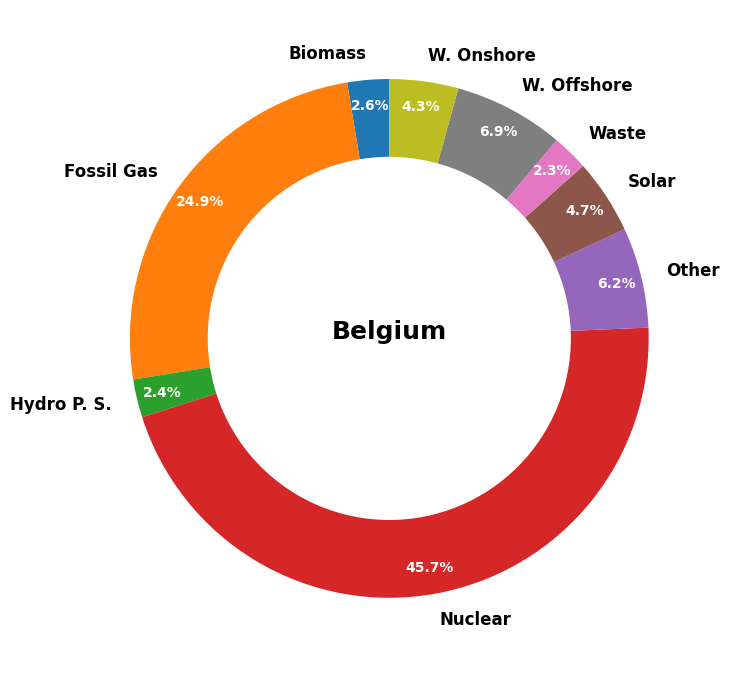

In [23]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
#labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'

explode = [0.05]*len(belf)
explode = tuple(explode)

fig1, ax1 = plt.subplots(figsize=(7,7))
wedges, texts, autotexts = ax1.pie(belf, autopct='%1.1f%%', startangle=90, labels = indbelf, pctdistance=0.9)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#ax1.legend(wedges, indbel,title= 'Sources', bbox_to_anchor=(1, 0, 0.5,1))

#draw circle
x=0
y=0
centre_circle = plt.Circle((0,0),0.70,fc='white')
label = ax1.annotate('Belgium', xy = (x,y), ha = 'center', fontsize = 18 , weight="bold")
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')
plt.tight_layout()
plt.setp(autotexts, size=10, weight="bold", color = "w")
plt.setp(texts, size=12, weight="bold")
plt.savefig('figuras/belgium_pie.pdf', bbox_inches='tight')
plt.show()


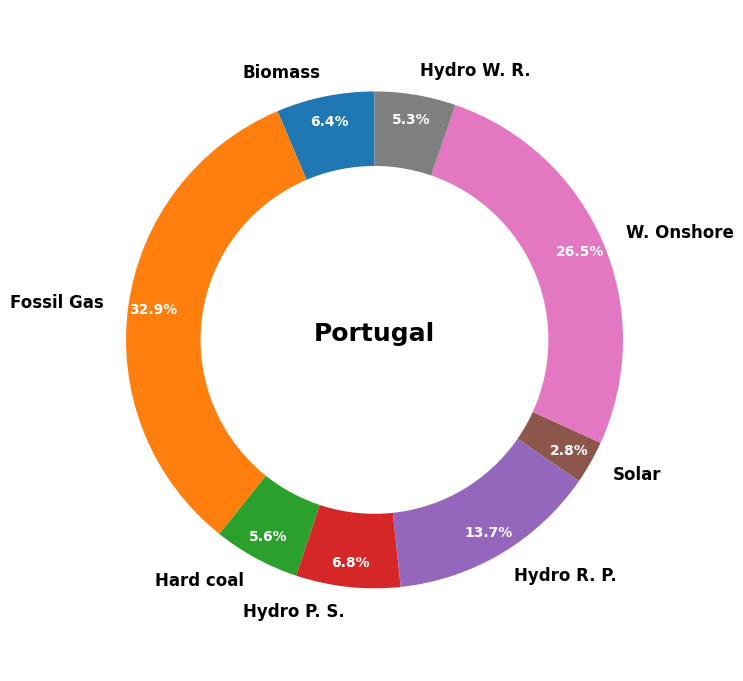

In [24]:
explode = [0.05]*len(porf)
explode = tuple(explode)
fig1, ax1 = plt.subplots(figsize = (7,7))
wedges, texts, autotexts = ax1.pie(porf, autopct='%1.1f%%', startangle=90, labels = indporf, pctdistance=0.9)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#ax1.legend(wedges, indbel,title= 'Sources', bbox_to_anchor=(1, 0, 0.5,1))

#draw circle
x=0
y=0
centre_circle = plt.Circle((0,0),0.70,fc='white')
label = ax1.annotate('Portugal', xy = (x,y), ha = 'center', fontsize = 18, weight="bold")
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')
plt.tight_layout()
plt.setp(autotexts, size=10, weight="bold", color = 'w')
plt.setp(texts, size=12, weight="bold")
plt.savefig('figuras/portugal_pie.pdf', bbox_inches='tight')
plt.show()



In [25]:
indgerf

['Biomass',
 'Fossil Gas',
 'Hard coal',
 'Hydro P. S.',
 'Hydro R. P.',
 'Nuclear',
 'Solar',
 'Waste',
 'W. Offshore',
 'W. Onshore',
 'Lignite']

In [26]:
gerf

[4581.802226550565,
 6326.934120073327,
 5126.924915979224,
 1106.6549610449129,
 1603.5328826764437,
 7505.736136571953,
 5108.967165062633,
 676.1527650473572,
 2845.8422414451575,
 11089.035355560647,
 10823.240413993279]

In [27]:
gerf = [4581.802226550565,
 10823.240413993279,
 6326.934120073327,
 1106.6549610449129,
5126.924915979224,
 1603.5328826764437,
 7505.736136571953,
 5108.967165062633,
 2845.8422414451575,
 11089.035355560647]

In [28]:
indgerf = ['Biomass',
 'Lignite',
 'Fossil Gas',
 'Hydro P. S.',
 'Hard coal',
 'Hydro R. P.',
 'Nuclear',
 'Solar',
 'W. Offshore',
 'W. Onshore']

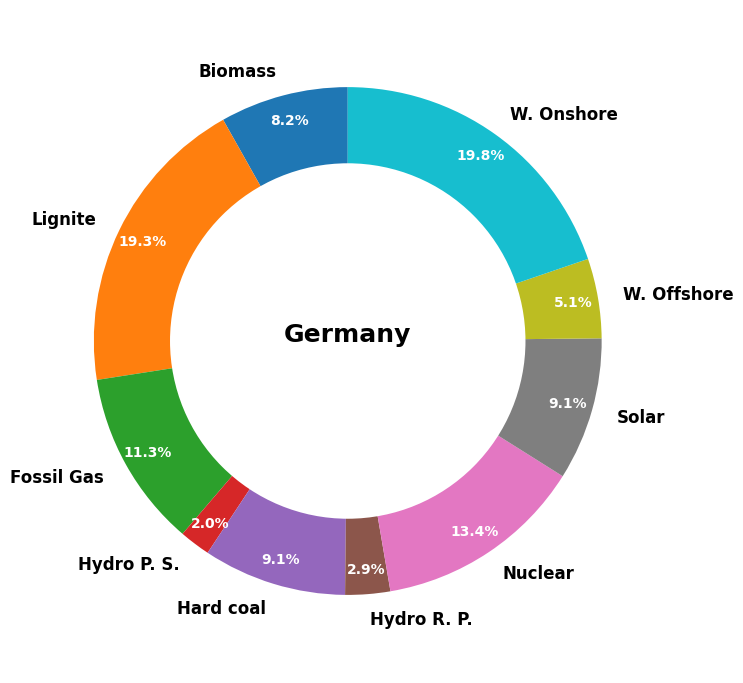

In [29]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
#labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'

explode = [0.05]*len(gerf)
explode = tuple(explode)

fig1, ax1 = plt.subplots(figsize=(7,7))
wedges, texts, autotexts = ax1.pie(gerf, autopct='%1.1f%%', startangle=90, labels = indgerf, pctdistance=0.9)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#ax1.legend(wedges, indbel,title= 'Sources', bbox_to_anchor=(1, 0, 0.5,1))

#draw circle
x=0
y=0
centre_circle = plt.Circle((0,0),0.70,fc='white')
label = ax1.annotate('Germany', xy = (x,y), ha = 'center', fontsize = 18 , weight="bold")
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')
plt.tight_layout()
plt.setp(autotexts, size=10, weight="bold", color = "w")
plt.setp(texts, size=12, weight="bold")
plt.savefig('figuras/germany_pie.pdf', bbox_inches='tight')
plt.show()

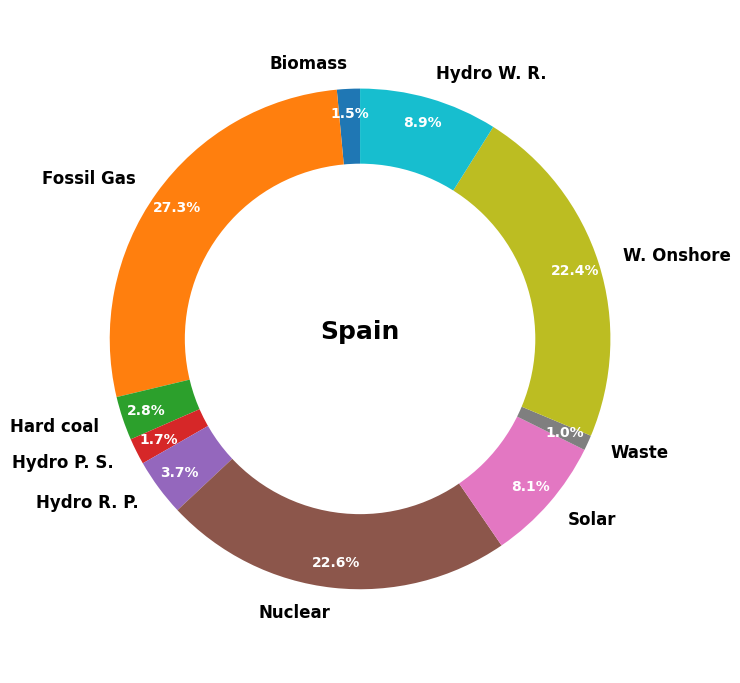

In [30]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
#labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'

explode = [0.05]*len(spaf)
explode = tuple(explode)

fig1, ax1 = plt.subplots(figsize=(7,7))
wedges, texts, autotexts = ax1.pie(spaf, autopct='%1.1f%%', startangle=90, labels = indspaf, pctdistance=0.9)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#ax1.legend(wedges, indbel,title= 'Sources', bbox_to_anchor=(1, 0, 0.5,1))

#draw circle
x=0
y=0
centre_circle = plt.Circle((0,0),0.70,fc='white')
label = ax1.annotate('Spain', xy = (x,y), ha = 'center', fontsize = 18 , weight="bold")
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')
plt.tight_layout()
plt.setp(autotexts, size=10, weight="bold", color = "w")
plt.setp(texts, size=12, weight="bold")
plt.savefig('figuras/spain_pie.pdf', bbox_inches='tight')
plt.show()

# Variable selection: source with generation higher than 1% of the total generation

In [31]:
indspaf.extend(['Date', 'Hour', 'Emission', 'Consumption'])
indgerf.extend(['Date', 'Hour', 'Emission', 'Consumption'])
indporf.extend(['Date', 'Hour', 'Emission', 'Consumption'])
indbelf.extend(['Date', 'Hour', 'Emission', 'Consumption'])

In [32]:
dadosbelgicat = dadosbelgicat[indbelf]
dadosalemanhat = dadosalemanhat[indgerf]
dadosespanhat = dadosespanhat[indspaf]
dadosportugalt = dadosportugalt[indporf]

In [33]:
out_file = open("dados_quantizados/dadosreais_portugal.pickle",'wb')
pickle.dump(dadosportugalt,out_file)
out_file.close()
dadosportugalt.to_sql(name='portugal', con = get_connection(),schema = 'pre_processed_data', if_exists = 'replace', chunksize = None, index = False)
dadosportugalt.head()

,Biomass,Fossil Gas,Hard coal,Hydro P. S.,Hydro R. P.,Solar,W. Onshore,Hydro W. R.,Date,Hour,Emission,Consumption
24,320.0,434.0,1472.0,345.0,655.0,0.0,543.0,283.0,2019/01/01,00:00,344.485272,4797.0
25,320.0,427.0,1470.0,243.0,492.0,0.0,441.0,303.0,2019/01/01,01:00,375.006995,4650.0
26,331.0,428.0,1470.0,0.0,421.0,0.0,367.0,294.0,2019/01/01,02:00,415.877398,4394.0
27,339.0,429.0,1407.0,0.0,116.0,0.0,346.0,220.0,2019/01/01,03:00,463.404366,4177.0
28,335.0,430.0,1289.0,0.0,114.0,0.0,413.0,130.0,2019/01/01,04:00,453.526988,4017.0


In [34]:
out_file = open("dados_quantizados/dadosreais_espanha.pickle",'wb')
pickle.dump(dadosespanhat,out_file)
out_file.close()
dadosespanhat.to_sql(name='espanha', con = get_connection(),schema = 'pre_processed_data', if_exists = 'replace', chunksize = None, index = False)
dadosespanhat.head()

,Biomass,Fossil Gas,Hard coal,Hydro P. S.,Hydro R. P.,Nuclear,Solar,Waste,W. Onshore,Hydro W. R.,Date,Hour,Emission,Consumption
0,286.0,5601.0,1919.0,107.0,983.0,6073.0,31.0,287.0,3809.0,1683.0,2019/01/01,00:00,200.279509,23401.0
1,296.0,5573.0,1707.0,60.0,969.0,6072.0,31.0,286.0,3774.0,1676.0,2019/01/01,01:00,194.656530,22699.0
2,298.0,5549.0,1638.0,499.0,907.0,6073.0,23.0,287.0,3740.0,1124.0,2019/01/01,02:00,194.886454,21336.0
3,296.0,6036.0,1516.0,1238.0,897.0,6073.0,15.0,288.0,3697.0,830.0,2019/01/01,03:00,193.723412,20184.0
4,295.0,5999.0,1486.0,1317.0,910.0,6073.0,15.0,289.0,3516.0,944.0,2019/01/01,04:00,192.660100,19430.0


In [35]:
out_file = open("dados_quantizados/dadosreais_alemanha.pickle",'wb')
pickle.dump(dadosalemanhat,out_file)
out_file.close()
dadosalemanhat.to_sql(name='alemanha', con = get_connection(),schema = 'pre_processed_data', if_exists = 'replace', chunksize = None, index = False)
dadosalemanhat.head()

,Biomass,Lignite,Fossil Gas,Hydro P. S.,Hard coal,Hydro R. P.,Nuclear,Solar,W. Offshore,W. Onshore,Date,Hour,Emission,Consumption
0,4930.75,6335.00,3273.25,274.50,2811.75,1471.25,9001.50,0.0,3136.50,19995.50,2019/01/01,00:00,199.063855,43012.75
1,4904.00,5379.50,2967.25,134.25,2404.25,1479.25,8535.25,0.0,2868.00,22036.50,2019/01/01,01:00,178.026157,41460.75
2,4866.50,5341.00,2720.25,154.25,2228.50,1413.75,7954.00,0.0,2459.50,22748.25,2019/01/01,02:00,175.406310,39921.75
3,4865.75,5270.75,2653.25,1.00,2356.75,1416.75,7221.75,0.0,2697.75,23870.25,2019/01/01,03:00,174.513502,39099.50
4,4867.25,5178.75,2706.00,4.50,2308.50,1393.25,7120.00,0.0,2578.25,25921.50,2019/01/01,04:00,167.842548,38886.25


In [36]:
out_file = open("dados_quantizados/dadosreais_belgica.pickle",'wb')
pickle.dump(dadosbelgicat,out_file)
out_file.close()
dadosbelgicat.to_sql(name='belgica', con = get_connection(),schema = 'pre_processed_data', if_exists = 'replace', chunksize = None, index = False)
dadosbelgicat.head()

,Biomass,Fossil Gas,Hydro P. S.,Nuclear,Other,Solar,Waste,W. Offshore,W. Onshore,Date,Hour,Emission,Consumption
0,159.0,1920.0,66.0,2376.0,633.0,0.0,259.0,493.0,272.0,2019/01/01,00:00,198.061776,8973.25
1,159.0,1637.0,347.0,2376.0,673.0,0.0,258.0,500.0,305.0,2019/01/01,01:00,181.472355,8542.75
2,159.0,1587.0,298.0,2383.0,631.0,0.0,259.0,554.0,292.0,2019/01/01,02:00,178.281799,8077.50
3,162.0,1598.0,197.0,2413.0,619.0,0.0,255.0,511.0,343.0,2019/01/01,03:00,179.262832,7823.25
4,165.0,1535.0,478.0,2416.0,619.0,0.0,254.0,609.0,392.0,2019/01/01,04:00,166.842736,7636.25


In [37]:
min(dadosportugalt['Date'])

'2019/01/01'

In [38]:
max(dadosespanhat['Date'])

'2021/12/30'

# Data quantisation

In [43]:
#Quantização dos dados e armazenando dos valores para conversão
from numpy import mean, size, zeros, where, transpose
from numpy.random import normal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
paises = ['belgica', 'portugal', 'espanha', 'alemanha']

for p in paises:
    teste = pd.read_pickle("dados_quantizados/dadosreais_"+str(p)+".pickle")
    teste['Hour'] = (np.arange(0,24).tolist())*round(len(teste)/24)
    dados=teste.copy()
    reals = {} #dicionário para armazenar os limites de cada bin para cada variavel
    for h in teste.columns:
        x=list(teste[h])
        if all(v == 0 for v in x) or h in ['Date', 'Hour']:
            dados[h]=dados[h]
        else:
            x_max = max(x)
            x_min = min(x)
            N_MIN = 4   #Minimum number of bins (integer)
                        #N_MIN must be more than 1 (N_MIN > 1).
            N_MAX = 40  #Maximum number of bins (integer)
            N = range(N_MIN,N_MAX) # #of Bins
            N = np.array(N)
            D = (x_max-x_min)/N    #Bin size vector
            C = zeros(shape=(size(D),1))

            #Computation of the cost function
            for i in range(size(N)):
                edges = np.linspace(x_min,x_max,N[i]+1) # Bin edges
                ki= plt.hist(x,edges)[0] # Count # of events in bins
                plt.clf()
                plt.close()
                #ki = ki[0]
                k = mean(ki) #Mean of event count
                v = sum((ki-k)**2)/N[i] #Variance of event count
                C[i] = (2*k-v)/((D[i])**2) #The cost Function
            #Optimal Bin Size Selection

            cmin = min(C)
            idx  = where(C==cmin)
            idx = int(idx[0])
            optD = D[idx]
            #print(N[idx])
            edges = np.linspace(x_min,x_max,N[idx]+1)
            edges=edges.tolist()
            edges[len(edges)-1]=edges[len(edges)-1]+0.5
            reals[h]=edges
            label=np.arange(0,len(edges)-1)
            label=label.tolist()
            dados[h] = list(pd.cut(x=teste[h], bins=edges, labels=label,right=False))
            dados[h]=dados[h].astype(np.int64)
    out_filel = open("dados_quantizados/intervalosdados"+str(p)+".pickle",'wb')
    pickle.dump(reals,out_filel)
    out_filel.close()
    t = pd.DataFrame.from_dict(reals,orient='index')
    t = t.transpose()
    t.to_sql(name='bins_'+str.lower(p), con = get_connection(),schema = 'pre_processed_data', if_exists = 'replace', chunksize = None, index = False)

    dados['Date'] = pd.to_datetime(dados['Date'])
    out_file = open("dados_quantizados/dadospreprocessados"+str(p)+".pickle",'wb')
    pickle.dump(dados,out_file)
    out_file.close()
    dados.to_sql(name='quantised_'+str.lower(p), con = get_connection(),schema = 'pre_processed_data', if_exists = 'replace', chunksize = None, index = False)


# Forecast horizon: mutual information

In [6]:
import warnings
import sys 
import logging
logging.disable()
if not sys.warnoptions:
    warnings.simplefilter("ignore")
def shift(seq, n=0):
    a = n % len(seq)
    return seq[-a:] + seq[:-a]

import logging
import random
import math
def MIxy(x, y): 
    """MIxy(x, y) -> MI
            x e y sao sinais
            valor = [[min(x), max(x)], [min(y), max(y)]]
            NBins eh o numero de bins usados para discretizar x e y
            essa funcao responde com a versao naive da estimativa da Informacao Mutua
    """
    from scipy.stats import entropy
    valor=[[np.min(x),np.max(x)],[np.min(y),np.max(y)]]
    hx=len(x)**(-1/3)*3.49*np.std(x)#largura bin 
    Binsx=(np.max(x)-np.min(x))/hx#numero de bins para x
    
    hy=len(y)**(-1/3)*3.49*np.std(y)#largura bin
    Binsy=(np.max(y)-np.min(y))/hy#numero de bins para y
    
    NBins=math.ceil(np.max([Binsx,Binsy]))#maior valor inteiro

    
    x = [float(i) for i in x]
    y = [float(i) for i in y]
         
    p, edges = np.histogramdd(x,     bins = NBins, range = [valor[0]])
    px = p/float(sum(p))
    p, edges = np.histogramdd(y,     bins = NBins, range = [valor[1]])
    py = p/float(sum(p))
    p, edges = np.histogramdd([x,y], bins = NBins, range = [valor[0],valor[1]])
    pxy = p/float(sum(sum(p)))
    MI = 0.0
    escala = range(NBins)
    entropX=entropy(px, base=2)
    entropY=entropy(py, base=2)
    minentrop=min([entropX,entropY])
    for j in escala:
        for i in escala:
            if px[i]!=0 and py[j]!=0 and pxy[i,j]!=0:
                MI = MI + pxy[i,j]*(np.log2(pxy[i,j]/(px[i]*py[j])))
    return round(MI/minentrop,2)

In [45]:
dados.columns

Index(['Biomass', 'Lignite', 'Fossil Gas', 'Hydro P. S.', 'Hard coal',
       'Hydro R. P.', 'Nuclear', 'Solar', 'W. Offshore', 'W. Onshore', 'Date',
       'Hour', 'Emission', 'Consumption'],
      dtype='object')

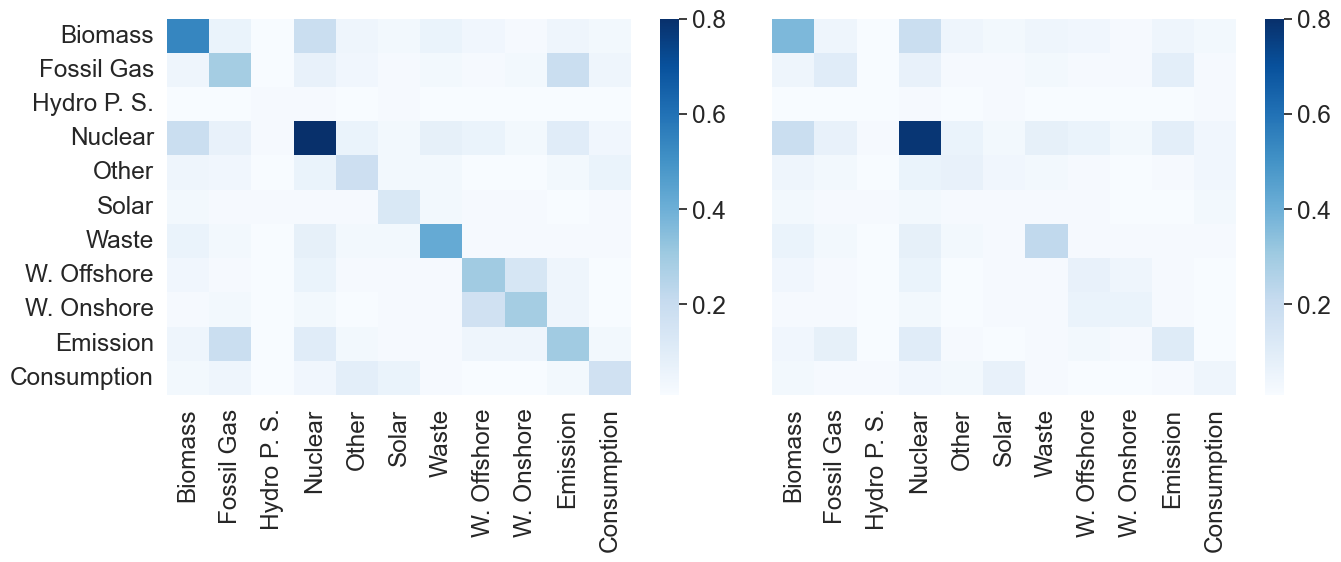

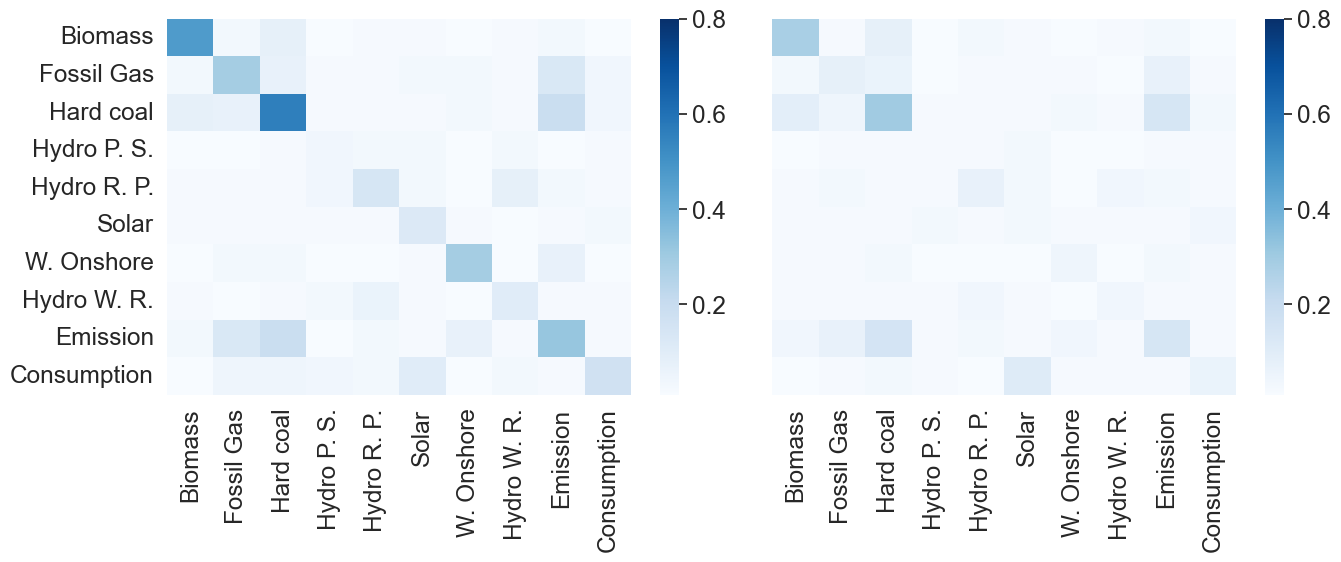

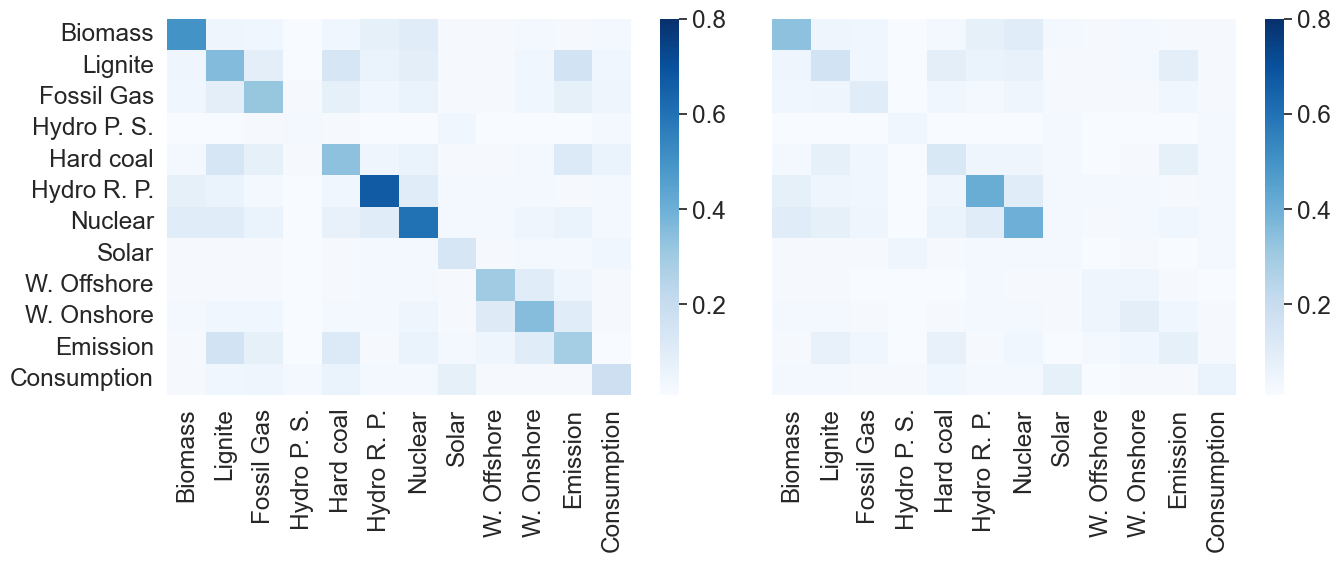

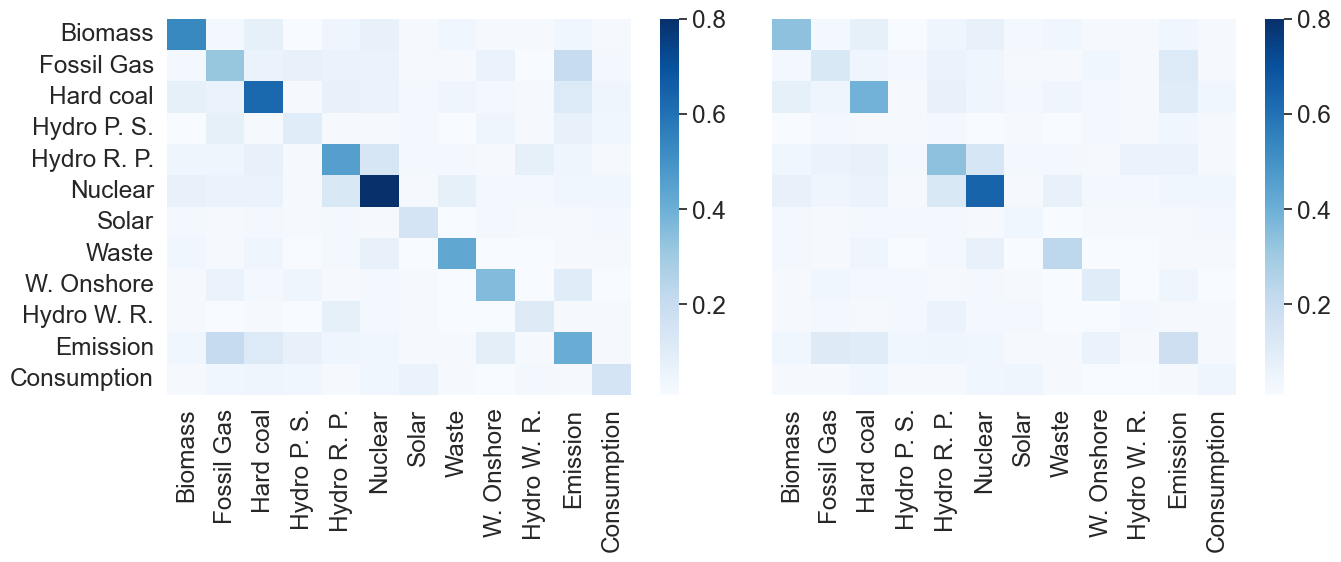

In [81]:
import seaborn as sns
paises = ['belgica', 'portugal', 'alemanha', 'espanha']
for p in paises:
    dados = pd.read_pickle("dados_quantizados/dadospreprocessados"+str(p)+".pickle")
    dados = dados.drop('Date',axis=1)
    dados = dados.drop('Hour',axis=1)
    variaveis=list(dados.columns)
    matrizes=[]
    atrasos=[3,12,17,24]
    for h in atrasos:
        matriz=[]
        for j in range(len(variaveis)):
            aux=[]
            dadostoday=list(dados[variaveis[j]][h:])
            for g in range(len(variaveis)):
                dadosdelay=shift(list(dados[variaveis[g]]),h)
                dadosdelay=dadosdelay[h:]
                aux.append(MIxy(dadostoday,dadosdelay))
            matriz.append(aux)
        matrizes.append(matriz)
    fig=plt.figure(figsize=(14,6))
    ax = fig.add_subplot(111)    
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
    sns.set(font_scale=1.6)
    ax1 = plt.subplot(121)
    ax1 = sns.heatmap(matrizes[0],annot=False,xticklabels=variaveis, yticklabels=variaveis,cmap="Blues",vmax=0.8)
    #ax1.xaxis.set_ticklabels([])
    ax2 = plt.subplot(122)
    ax2 = sns.heatmap(matrizes[2],annot=False,xticklabels=variaveis, yticklabels=variaveis,cmap="Blues",vmax=0.8)
    ax2.yaxis.set_ticklabels([])
    #ax2.xaxis.set_ticklabels([])
    #ax3 = plt.subplot(223)
    #ax3 = sns.heatmap(matrizes[2],annot=False,xticklabels=variaveis, yticklabels=variaveis,cmap="Blues",vmax=0.8)
    #ax4 = plt.subplot(224)
    #ax4 = sns.heatmap(matrizes[3],annot=False,xticklabels=variaveis, yticklabels=variaveis,cmap="Blues",vmax=0.8)
    #ax4.yaxis.set_ticklabels([])
    fig.tight_layout()
    plt.savefig('figuras/MI_'+str(p)+'.pdf', bbox_inches='tight')
    plt.show()

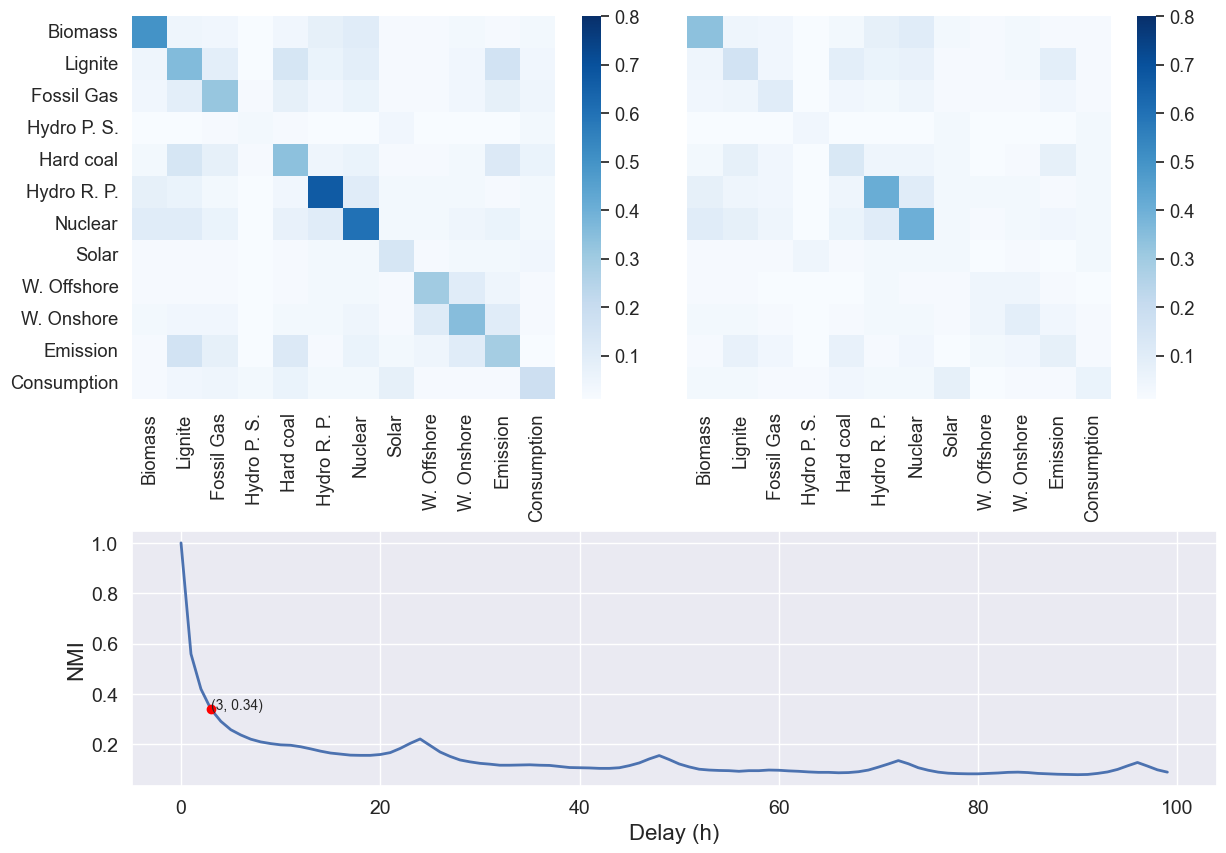

In [65]:
paises = ['alemanha']
for p in paises:
    dados = pd.read_pickle("dados_quantizados/dadospreprocessados"+str(p)+".pickle")
    dados = dados.drop('Date',axis=1)
    dados = dados.drop('Hour',axis=1)
    variaveis=list(dados.columns)
    matrizes=[]
    atrasos=[3,12,17,24]
    for h in atrasos:
        matriz=[]
        for j in range(len(variaveis)):
            aux=[]
            dadostoday=list(dados[variaveis[j]][h:])
            for g in range(len(variaveis)):
                dadosdelay=shift(list(dados[variaveis[g]]),h)
                dadosdelay=dadosdelay[h:]
                aux.append(MIxy(dadostoday,dadosdelay))
            matriz.append(aux)
        matrizes.append(matriz)
    dados = pd.read_pickle("dados_quantizados/dadospreprocessados"+str(p)+".pickle")
    dados = dados.drop('Date',axis=1)
    dados = dados.drop('Hour',axis=1)
    variaveis=list(dados.columns)
    matrizes2=[]
    diagonal2=[]
    atrasos=np.arange(0,100)
    for h in atrasos:
        matriz2=[]
        for j in range(len(variaveis)):
            aux=[]
            dadostoday=list(dados[variaveis[j]][h:])
            dadosdelay=shift(list(dados[variaveis[j]]),h)
            dadosdelay=dadosdelay[h:]
            aux.append(MIxy(dadostoday,dadosdelay))
            matriz2.append(aux)
        diagonal2.append(np.mean(matriz))
        matrizes2.append(matriz2)
fig=plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)    
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
sns.set(font_scale=1.2)
ax1 = plt.subplot(221)
ax1 = sns.heatmap(matrizes[0],annot=False,xticklabels=variaveis, yticklabels=variaveis,cmap="Blues",vmax=0.8)
#ax1.xaxis.set_ticklabels([])
ax2 = plt.subplot(222)
sns.set(font_scale=1.2)
ax2 = sns.heatmap(matrizes[2],annot=False,xticklabels=variaveis, yticklabels=variaveis,cmap="Blues",vmax=0.8)
ax2.yaxis.set_ticklabels([])
#ax2.xaxis.set_ticklabels([])
#ax3 = plt.subplot(223)
#ax3 = sns.heatmap(matrizes[2],annot=False,xticklabels=variaveis, yticklabels=variaveis,cmap="Blues",vmax=0.8)
#ax4 = plt.subplot(224)
#ax4 = sns.heatmap(matrizes[3],annot=False,xticklabels=variaveis, yticklabels=variaveis,cmap="Blues",vmax=0.8)
#ax4.yaxis.set_ticklabels([])
ax3 = plt.subplot(313)
ax3.plot(atrasos,diagonal, linewidth = 2)
plt.xlabel('Delay (h)',fontsize=16)
plt.ylabel('NMI', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(atrasos[3],diagonal[3],'o', color='red')
plt.annotate(str('(')+str(atrasos[3])+str(', ')+str(np.round(diagonal[3],2))+str(')'),(atrasos[3],diagonal[3]), fontsize=10)

fig.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.01)
plt.savefig('figuras/MI_alemanha_junto.pdf', bbox_inches='tight')
plt.show()

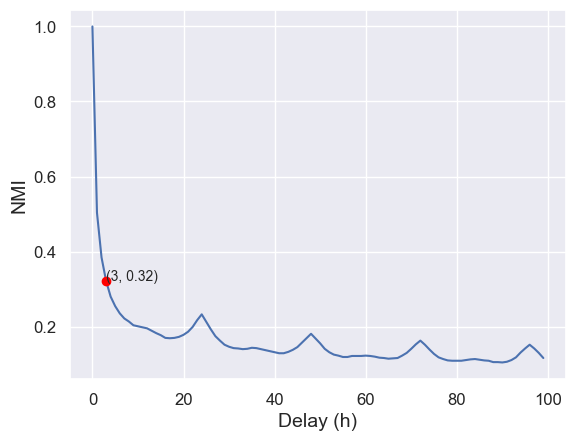

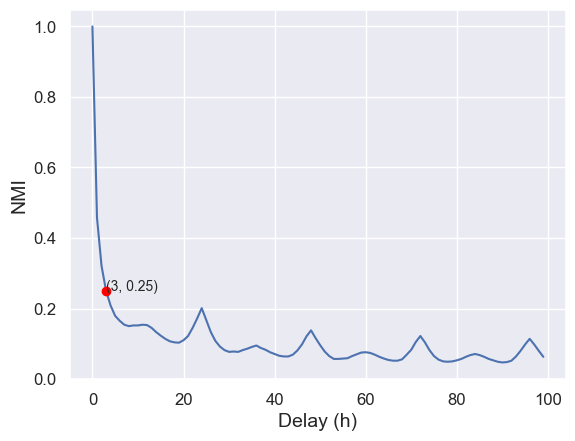

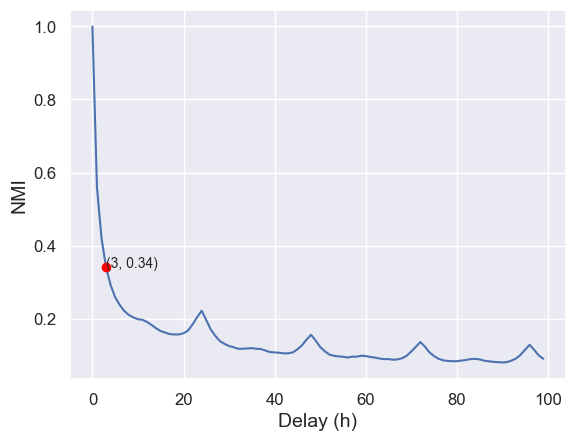

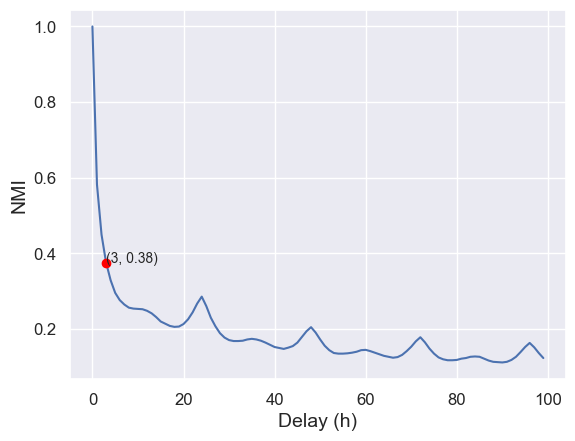

In [36]:
paises = ['belgica', 'portugal', 'alemanha', 'espanha']
for p in paises:
    dados = pd.read_pickle("dados_quantizados/dadospreprocessados"+str(p)+".pickle")
    dados = dados.drop('Date',axis=1)
    dados = dados.drop('Hour',axis=1)
    variaveis=list(dados.columns)
    matrizes=[]
    diagonal=[]
    atrasos=np.arange(0,100)
    for h in atrasos:
        matriz=[]
        for j in range(len(variaveis)):
            aux=[]
            dadostoday=list(dados[variaveis[j]][h:])
            dadosdelay=shift(list(dados[variaveis[j]]),h)
            dadosdelay=dadosdelay[h:]
            aux.append(MIxy(dadostoday,dadosdelay))
            matriz.append(aux)
        diagonal.append(np.mean(matriz))
        matrizes.append(matriz)
    plt.figure()
    plt.plot(atrasos,diagonal)
    plt.xlabel('Delay (h)',fontsize=14)
    plt.ylabel('NMI', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.plot(atrasos[3],diagonal[3],'o', color='red')
    plt.annotate(str('(')+str(atrasos[3])+str(', ')+str(np.round(diagonal[3],2))+str(')'),(atrasos[3],diagonal[3]), fontsize=10)
    plt.savefig('figuras/MI_diagonal_'+str(p)+'.pdf', bbox_inches='tight')
    plt.show()

# Data preparation to dynamic model

In [48]:
#Após o pre-processamento (quantização), prepara o dataset para o modelo dinâmico
#função para deslocamento
def shift(seq, n=0):
    a = n % len(seq)
    return seq[-a:] + seq[:-a]
horizonte = 3 #1 ponto por hora
paises = ['belgica', 'portugal', 'alemanha', 'espanha']
for p in paises:
    dados = pd.read_pickle("dados_quantizados/dadospreprocessados"+str(p)+".pickle")
    dados['Date'] = pd.to_datetime(dados['Date'])
    dadosok = pd.DataFrame()
    for i in dados.columns:
        if i in ['Date','Hour']:
            dadosok[i] = dados[i]
        else:
            dadosok[i] = dados[i]
            dadosok[i+str("-1")] = shift(list(dados[i]),horizonte)
    out_file = open("dados_quantizados/dadospreprocessados_dbn"+str(p)+".pickle",'wb')
    pickle.dump(dadosok,out_file)
    dadosok.to_sql(name='dbn_'+str.lower(p), con = get_connection(),schema = 'pre_processed_data', if_exists = 'replace', chunksize = None, index = False)


# Variables selection

18       Emission-1
2        Fossil Gas
3      Fossil Gas-1
6           Nuclear
7         Nuclear-1
14      W. Offshore
16       W. Onshore
0           Biomass
17     W. Onshore-1
1         Biomass-1
15    W. Offshore-1
Name: VARIABLES, dtype: object


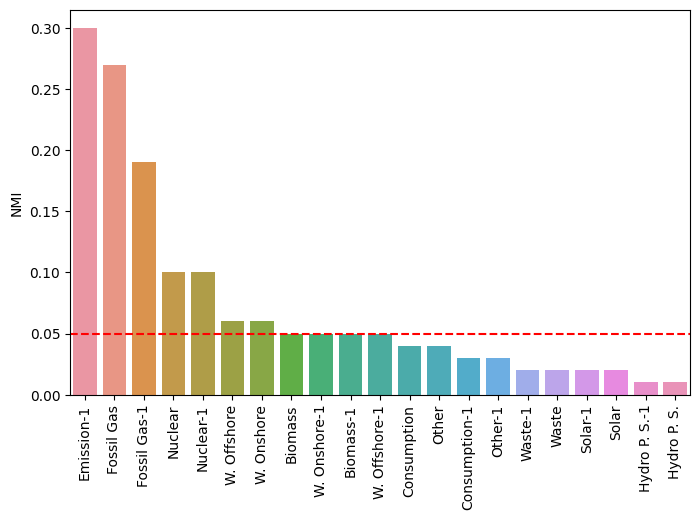

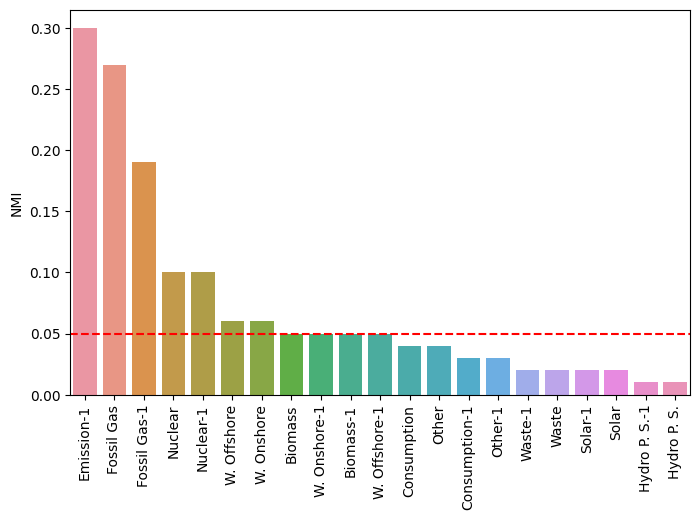

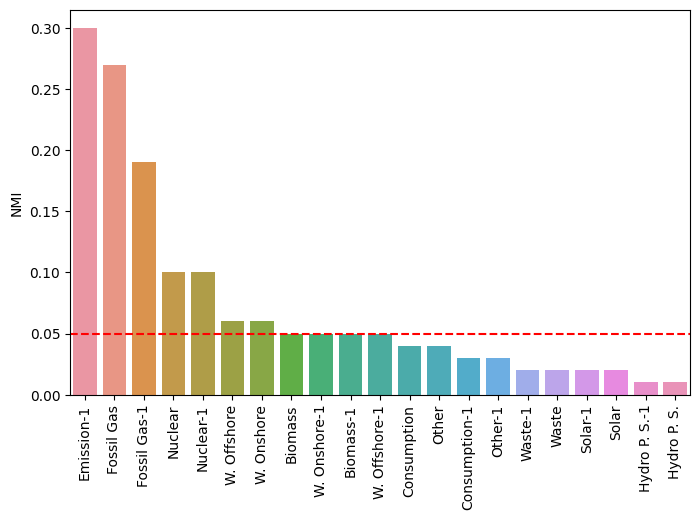

 
16      Emission-1
4        Hard coal
5      Hard coal-1
2       Fossil Gas
3     Fossil Gas-1
12      W. Onshore
13    W. Onshore-1
Name: VARIABLES, dtype: object


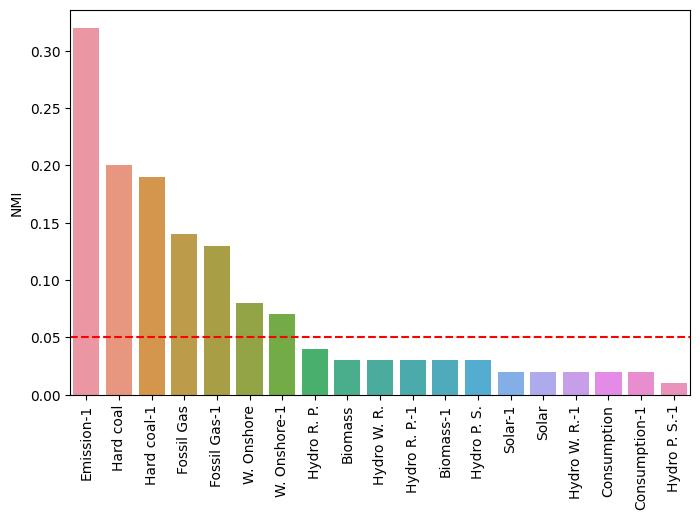

 
20       Emission-1
2           Lignite
3         Lignite-1
8         Hard coal
9       Hard coal-1
18       W. Onshore
4        Fossil Gas
19     W. Onshore-1
5      Fossil Gas-1
12          Nuclear
13        Nuclear-1
14            Solar
16      W. Offshore
17    W. Offshore-1
Name: VARIABLES, dtype: object


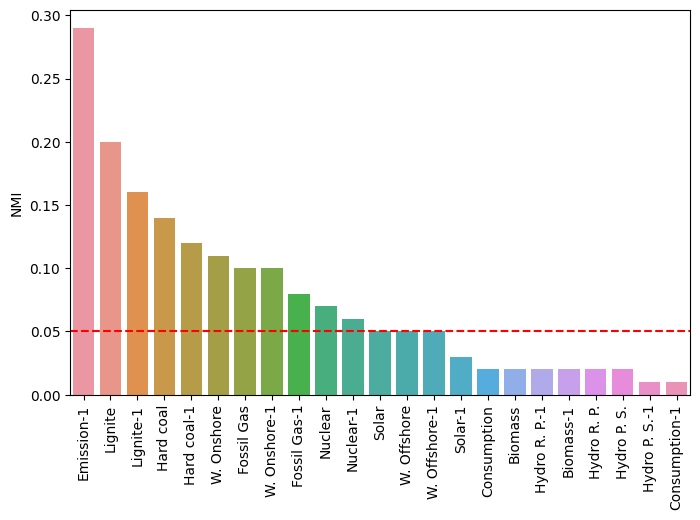

 
20       Emission-1
2        Fossil Gas
3      Fossil Gas-1
4         Hard coal
5       Hard coal-1
16       W. Onshore
6       Hydro P. S.
17     W. Onshore-1
7     Hydro P. S.-1
8       Hydro R. P.
9     Hydro R. P.-1
Name: VARIABLES, dtype: object


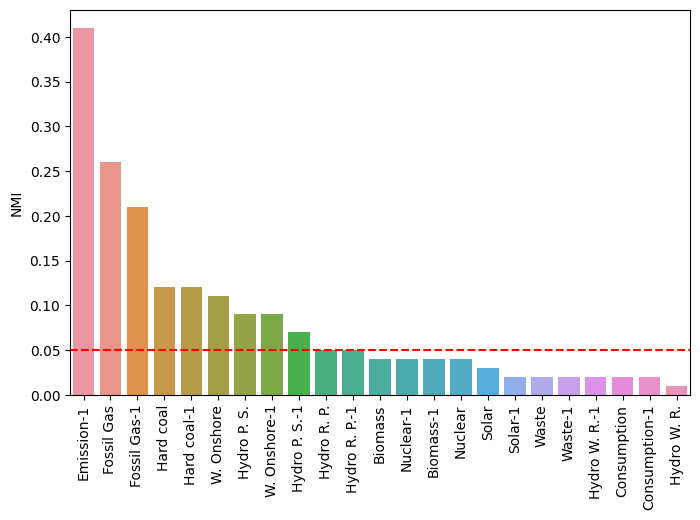

In [16]:
paises = ['belgica', 'portugal', 'alemanha', 'espanha']
title = ['Belgium', 'Portugal', 'Germany', 'Spain']
for p in range(len(paises)):
    cols = ['Date', 'Hour', 'Emission']
    teste = pd.read_pickle("dados_quantizados/dadospreprocessados_dbn"+str(paises[p])+".pickle")
    target = teste['Emission']
    variavel = []
    nmi = []
    for i in teste.columns:
        if i not in ['Date', 'Hour', 'Emission']:
            variavel.append(i)
            nmi.append(MIxy(target, teste[i]))
    df_nmi = pd.DataFrame()
    df_nmi['VARIABLES'] = variavel
    df_nmi['NMI'] = nmi
    df_nmi = df_nmi.sort_values('NMI', ascending = False)
    plt.figure(figsize = (8,5))
    sns.barplot(x = 'VARIABLES', y = 'NMI', data = df_nmi)
    plt.xticks(rotation = 90)
    #plt.grid(alpha = 0.4)
    plt.axhline(y = 0.05, color = 'r', linestyle = '--')
    #plt.title(title[p], fontsize = 14)
    plt.xlabel(None)
    #plt.ylabel('NMI', fontsize = 14)
    print(df_nmi['VARIABLES'][df_nmi['NMI']>=0.05])
    plt.savefig('figuras/feature_selection_'+str(paises[p])+'.pdf', bbox_inches='tight')
    cols.extend(df_nmi['VARIABLES'][df_nmi['NMI']>=0.05].tolist())
    teste = teste[cols]
    out_file = open("dados_quantizados/dbn_features_selected"+str(paises[p])+".pickle",'wb')
    pickle.dump(teste,out_file)
    teste.to_sql(name='dbn_features_selected_'+str.lower(paises[p]), con = get_connection(),schema = 'pre_processed_data', if_exists = 'replace', chunksize = None, index = False)

    plt.show()
    print(' ')

In [10]:
df_nmi['VARIABLES'][df_nmi['NMI']>=0.05].tolist()

['Emission-1',
 'Fossil Gas',
 'Fossil Gas-1',
 'Hard coal',
 'Hard coal-1',
 'W. Onshore',
 'Hydro P. S.',
 'W. Onshore-1',
 'Hydro P. S.-1',
 'Hydro R. P.',
 'Hydro R. P.-1']

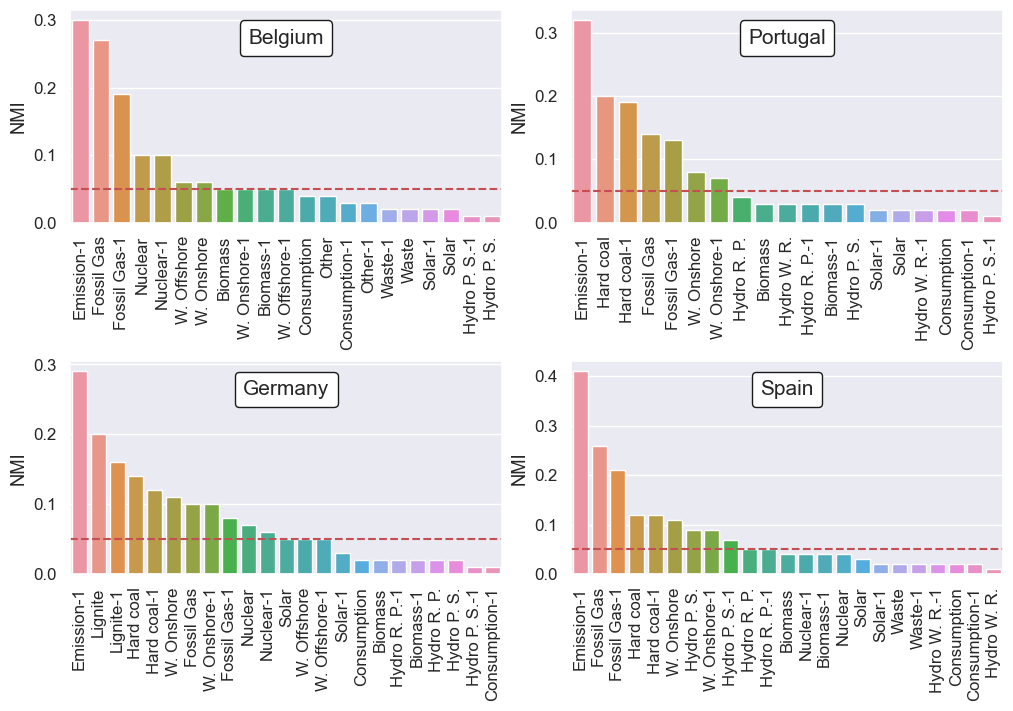

In [62]:
from matplotlib.offsetbox import AnchoredText
paises = ['belgica', 'portugal', 'alemanha', 'espanha']
title = ['Belgium', 'Portugal', 'Germany', 'Spain']
fig=plt.figure(figsize=(10,7),constrained_layout = True)
ax = fig.add_subplot(111)    
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
sns.set(font_scale=1.1)
for p in range(len(paises)):
    teste = pd.read_pickle("dados_quantizados/dadospreprocessados_dbn"+str(paises[p])+".pickle")
    target = teste['Emission']
    variavel = []
    nmi = []
    for i in teste.columns:
        if i not in ['Date', 'Hour', 'Emission']:
            variavel.append(i)
            nmi.append(MIxy(target, teste[i]))
    df_nmi = pd.DataFrame()
    df_nmi['VARIABLES'] = variavel
    df_nmi['NMI'] = nmi
    df_nmi = df_nmi.sort_values('NMI', ascending = False)
    #plt.figure(figsize = (8,5))
    if p ==0:
        ax1 = plt.subplot(221)
        ax1 = sns.barplot(x = 'VARIABLES', y = 'NMI', data = df_nmi)
        plt.xticks(rotation = 90)
        #plt.grid(alpha = 0.4)
        plt.axhline(y = 0.05, color = 'r', linestyle = '--')
        #plt.title(title[p], fontsize = 14)
        plt.xlabel(None)
        at = AnchoredText(
            title[p], prop=dict(size=15), frameon=True, loc='upper center')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax1.add_artist(at)
        #plt.ylabel('NMI', fontsize = 14)
        #print(df_nmi['VARIABLES'][df_nmi['NMI']>=0.05])
    if p ==1:
        ax2 = plt.subplot(222)
        ax2 = sns.barplot(x = 'VARIABLES', y = 'NMI', data = df_nmi)
        plt.xticks(rotation = 90)
        #plt.grid(alpha = 0.4)
        plt.axhline(y = 0.05, color = 'r', linestyle = '--')
        #plt.title(title[p], fontsize = 14)
        plt.xlabel(None)
        at = AnchoredText(
            title[p], prop=dict(size=15), frameon=True, loc='upper center')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax2.add_artist(at)
        #plt.ylabel('NMI', fontsize = 14)
        #print(df_nmi['VARIABLES'][df_nmi['NMI']>=0.05])
    if p ==2:
        ax2 = plt.subplot(223)
        ax2 = sns.barplot(x = 'VARIABLES', y = 'NMI', data = df_nmi)
        plt.xticks(rotation = 90)
        #plt.grid(alpha = 0.4)
        plt.axhline(y = 0.05, color = 'r', linestyle = '--')
        #plt.title(title[p], fontsize = 14)
        plt.xlabel(None)
        at = AnchoredText(
            title[p], prop=dict(size=15), frameon=True, loc='upper center')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax2.add_artist(at)
        #plt.ylabel('NMI', fontsize = 14)
        #print(df_nmi['VARIABLES'][df_nmi['NMI']>=0.05])
    if p ==3:
        ax2 = plt.subplot(224)
        ax2 = sns.barplot(x = 'VARIABLES', y = 'NMI', data = df_nmi)
        plt.xticks(rotation = 90)
        #plt.grid(alpha = 0.4)
        plt.axhline(y = 0.05, color = 'r', linestyle = '--')
        #plt.title(title[p], fontsize = 14)
        plt.xlabel(None)
        at = AnchoredText(
            title[p], prop=dict(size=15), frameon=True, loc='upper center')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax2.add_artist(at)
        #plt.ylabel('NMI', fontsize = 14)
        #print(df_nmi['VARIABLES'][df_nmi['NMI']>=0.05])
plt.savefig('figuras/feature_selection_todos'+'.pdf', bbox_inches='tight')
plt.show()
